In [1]:
import os
import json

import numpy as np

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
from src.jump import Jump
from pso import *

In [3]:
BEG_OF_TIME = '2016-06-01'
END_OF_TIME = '2020-09-30'

PSO_HP = PSOHyperparameters(
    inertia = 0.09,
    inertia_dampening = 0.99,
    cognitive_acceleration = 1.0,
    social_acceleration = 1.0,
)

PSO_POPULATION = 100
PSO_NB_ITER    = 100

In [4]:
def get_asset_returns(asset):
    """
    get complete return time serie for an asset
    """
    returns = []

    beg_date  = datetime.strptime(BEG_OF_TIME, '%Y-%m-%d').date()
    prev_date = beg_date - timedelta(days=32)
    prev_value = 0.0

    first_return = None

    def add_return(current_date, ret):
        if current_date >= beg_date:
            returns.append(ret)

    for i, values in enumerate(asset["values"]):
        current_date = datetime.strptime(values["date"], '%Y-%m-%d').date()
        
        if current_date <= beg_date:
            first_return = current_date
        
        nb_days = (current_date - prev_date).days
        diff = (values["return"] - prev_value) / nb_days

        for i in range(nb_days - 1):
            add_return(prev_date + timedelta(days=i+1), prev_value)
        add_return(current_date, values["return"])

        prev_value = values["return"]
        prev_date = current_date

    return first_return, returns

In [5]:
def plot_history(history):
    plt.plot(history)
    plt.ylabel('fitness')
    plt.xlabel('iteration')
    plt.title('Evolution of fitnesss')
    plt.show()

In [6]:
def check_constraints(best_particle, nb_funds):
    stock_perc = np.sum(best_particle[nb_funds:])

    nav_ok = np.all(np.logical_and(
        np.logical_or(best_particle == 0, best_particle >= 0.01),
        best_particle < 0.1,
    ))

    nb_assets = np.sum(best_particle >= 0.01)

    print(f"[{'OK' if stock_perc > 0.5 else 'KO'}] Stock %: {stock_perc:.2f}")
    print(f"[{'OK' if nav_ok else 'KO'}] %Nav")
    print(f"[{'OK' if nb_assets > 15 else 'KO'}] Asset count: {nb_assets}")

## Preprocessing

### Load assets & get returns time series

In [7]:
asset_dict = Jump().get_all_assets("assets_cache.json", start_date="2016-05-01")

returns_list = []
to_del = []
first_returns = {}

for k, asset in asset_dict.items():
    first_return, returns = get_asset_returns(asset)

    if first_return is None:
        label = asset["label"]
        fdate = asset["values"][0]["date"]

        print(f"Drop id={k:5}, date={fdate:15} name={label}")
        to_del.append(k)
    else:
        first_returns[k] = first_return
        returns_list.append(returns)

for td in to_del:
    del asset_dict[td]
        
returns_list = np.array(returns_list)

Drop id=2124 , date=2018-10-22      name=29 HAUSSMANN EQUILIBRE
Drop id=1428 , date=2018-10-22      name=AAA - ACTIONS AGRO ALIM.I FCP
Drop id=2155 , date=2018-10-22      name=ABERDEEN FUNDS GLOBAL PHARMA EQUITY - A
Drop id=2125 , date=2018-10-22      name=ABERDEEN GLOBAL ASIA PACIFIC EQUITY E2
Drop id=2126 , date=2018-10-22      name=ABERDEEN GLOBAL - ASIA PACIFIC EQU - X ACC (EUR)
Drop id=2130 , date=2018-10-22      name=ACA - HORIZON MONDE (EUR)
Drop id=1855 , date=2017-05-10      name=ADOMOS
Drop id=1867 , date=2018-10-22      name=ALLIANZ SE-VINK
Drop id=1904 , date=2017-10-25      name=BANCA MONTE DEI
Drop id=1954 , date=2016-07-20      name=CGG
Drop id=1955 , date=2018-06-14      name=CGGVERITAS
Drop id=1957 , date=2016-06-10      name=CHAUSSERIA
Drop id=1488 , date=2016-08-26      name=CPR-SILVER AGE-I
Drop id=1974 , date=2016-10-26      name=CYBERGUN
Drop id=2087 , date=2018-10-22      name=DELL INC
Drop id=2048 , date=2018-10-22      name=FRESENIUS MEDICA
Drop id=2049 , date=

### Split funds and stocks

In [8]:
funds_keys = []
stock_keys = []

funds_returns = []
stock_returns = []

funds_real_count = []
funds_price = []
stock_price = []

ref_portfolio = None
our_portfolio = None

for i, (k, v) in enumerate(asset_dict.items()):
    if v["type"] in ("ETF FUND", "FUND", "INDEX"):
        nav = v["values"][0]["values_usd"]["nav"]

        funds_keys.append(k)
        funds_returns.append(returns_list[i])
        funds_price.append(nav)
        funds_real_count.append(1)
        # FIXME funds decimalisation: need to divide price and count

    elif v["type"] in ("STOCK",):
        nav = v["values"][0]["values_usd"]["nav"]

        stock_keys.append(k)
        stock_returns.append(returns_list[i])
        stock_price.append(nav)

    elif v["type"] in ("PORTFOLIO","LOUCHE"):
        if v["label"] == "REF":
            ref_portfolio = k, v
        else:
            our_portfolio = k, v

len(funds_keys), len(stock_keys)

(130, 331)

### Get values for PSO

In [9]:
funds_covariance = np.cov(funds_returns)
stock_covariance = np.cov(stock_returns)

funds_values = np.mean(funds_returns, axis=1)
stock_values = np.mean(stock_returns, axis=1)

## Run PSO for stocks

In [10]:
StockPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(stock_values),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=stock_values,
    covariance_matrix=stock_covariance,
)

In [11]:
best_stock_particle, history = StockPSO.run(200)

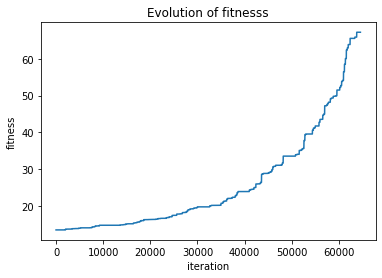

In [12]:
plot_history(history)

## Run PSO for funds

In [13]:
FundsPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(funds_values),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=funds_values,
    covariance_matrix=funds_covariance,
)

In [14]:
best_funds_particle, history = FundsPSO.run(PSO_NB_ITER)

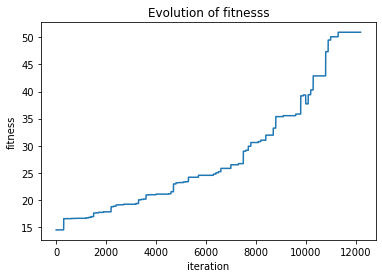

In [15]:
plot_history(history)

# Construct complete portfolio

In [16]:
returns = np.concatenate((funds_returns, stock_returns))
values = np.mean(returns, axis=1)
covariance = np.cov(returns)
prices = np.concatenate((funds_price, stock_price))
real_counts = np.concatenate((funds_real_count, np.ones(len(stock_price))))

best_particle = np.concatenate((best_funds_particle*0.49, best_stock_particle*0.51))

#### Check if constraints are respected

In [17]:
check_constraints(best_particle, len(funds_returns))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute total fitness

In [18]:
TestPSO = ParticleSwarmOptimizer(
    population_size=0,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(returns),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=values,
    covariance_matrix=covariance,
)
TestPSO.fitness(best_particle)

97.50570073080141

# Compute final portfolio

In [19]:
np.max(funds_price), np.max(stock_price)

(218797.41285, 5182.900431)

In [20]:
def nav_to_count(total, prices, nav):
    return ((total * nav) / prices).astype(np.int32)

def count_to_nav(total, prices, count):
    return (count * prices) / total

def price_error(total, prices, nav):
    diff = nav - count_to_nav(total, prices, nav_to_count(total, prices, nav))
    return np.sum(np.abs(diff))

total_price = 100000

while price_error(total_price, prices, best_particle) > 0.001:
    total_price *= 2

portfolio_titles = nav_to_count(total_price, prices, best_particle).astype(np.int32)
f"{total_price:,}$"

'204,800,000$'

### Let's check if the approximation was successful

In [21]:
final_particle = count_to_nav(total_price, prices, portfolio_titles)
np.max(np.abs(final_particle - best_particle))

0.0003420228310819923

In [22]:
TestPSO.fitness(final_particle)

97.52472717303627

In [23]:
check_constraints(final_particle, len(funds_returns))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute real portfolio

In [24]:
# funds decimalisation
final_portfolio_counts = portfolio_titles * real_counts

# back to IDs!
final_portfolio = {}
keys = np.concatenate((funds_keys, stock_keys))

for i, v in enumerate(final_portfolio_counts):
    if v == 0:
        continue

    asset = asset_dict[keys[i]]
    date = BEG_OF_TIME #str(first_returns[keys[i]])

    final_portfolio.setdefault(date, []).append({
        "asset": {
            "asset": int(keys[i]),
            "quantity": int(v),
        }
    })

final_portfolio

{'2016-06-01': [{'asset': {'asset': 2154, 'quantity': 552590}},
  {'asset': {'asset': 2142, 'quantity': 20917}},
  {'asset': {'asset': 2158, 'quantity': 83495}},
  {'asset': {'asset': 2164, 'quantity': 236511}},
  {'asset': {'asset': 1541, 'quantity': 5540}},
  {'asset': {'asset': 1559, 'quantity': 51696}},
  {'asset': {'asset': 2189, 'quantity': 50981}},
  {'asset': {'asset': 1608, 'quantity': 30885}},
  {'asset': {'asset': 1732, 'quantity': 79}},
  {'asset': {'asset': 2062, 'quantity': 138352}},
  {'asset': {'asset': 2068, 'quantity': 165534}},
  {'asset': {'asset': 1910, 'quantity': 135974}},
  {'asset': {'asset': 2074, 'quantity': 47151}},
  {'asset': {'asset': 1931, 'quantity': 144625}},
  {'asset': {'asset': 1956, 'quantity': 885926}},
  {'asset': {'asset': 2024, 'quantity': 54999}},
  {'asset': {'asset': 2045, 'quantity': 325158}},
  {'asset': {'asset': 1730, 'quantity': 810190}}]}

# Upload portfolio

In [28]:
portfolio_obj = {
    "label": "EPITA_PTF_1",
    "currency": {
        "code": "EUR"
    },
    "type": "front",
    "values": final_portfolio,
}

Jump().update_portfolio(our_portfolio[0], portfolio_obj)

<Response [200]>

### Check sharp ratio

In [29]:
results = Jump().calculate_ratio(ratio_ids=[12], asset_ids=[our_portfolio[0], ref_portfolio[0]]).json()

print(f"Our ratio: {results[our_portfolio[0]]['12']['value']}")
print(f"Ref ratio: {results[ref_portfolio[0]]['12']['value']}")

Our ratio: 2,190261458429
Ref ratio: 0,146571943186


In [27]:
Jump().get_portfolio(our_portfolio[0])

{'label': 'EPITA_PTF_1',
 'currency': {'code': 'EUR'},
 'type': 'front',
 'values': {'2016-06-01': [{'asset': {'asset': 1730, 'quantity': 810190.0}},
   {'asset': {'asset': 1732, 'quantity': 79.0}},
   {'asset': {'asset': 1956, 'quantity': 885926.0}},
   {'asset': {'asset': 1541, 'quantity': 5540.0}},
   {'asset': {'asset': 1608, 'quantity': 30885.0}},
   {'asset': {'asset': 2024, 'quantity': 54999.0}},
   {'asset': {'asset': 2154, 'quantity': 552590.0}},
   {'asset': {'asset': 1931, 'quantity': 144625.0}},
   {'asset': {'asset': 2189, 'quantity': 50981.0}},
   {'asset': {'asset': 2158, 'quantity': 83495.0}},
   {'asset': {'asset': 2062, 'quantity': 138352.0}},
   {'asset': {'asset': 2164, 'quantity': 236511.0}},
   {'asset': {'asset': 2068, 'quantity': 165534.0}},
   {'asset': {'asset': 1910, 'quantity': 135974.0}},
   {'asset': {'asset': 1559, 'quantity': 51696.0}},
   {'asset': {'asset': 2074, 'quantity': 47151.0}},
   {'asset': {'asset': 2045, 'quantity': 325158.0}},
   {'asset': {